In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from CLEARview import lattice, aperture, elements, opticsUtils, plot
import time
import pandas as pd

In [2]:
# Relativistic parametres 
P0 = 200.0                    #[MeV]
m0c2 = 511e-03                #[MeV]
E0 = np.sqrt(m0c2**2 + P0**2) #[MeV]

# Initial twiss parametres 
N = 200         # Number of particles
epsn_x = 10.0   #[um]
epsn_y = 10.0   #[um]

# Find geometrical emittance
epsg_x = opticsUtils.get_eps_g(epsn_x,E0) 
epsg_y = opticsUtils.get_eps_g(epsn_y,E0) 

# Constraints in Plasma lens
#sigma_PL = 0.2e-03     #[m]
#alpha_PL = 0.0

# Initial beta and alpha in the position of the Plasma lens
beta0x = 0.5002
alpha0x = 0.02
beta0y = 0.5002
alpha0y = 0.02

x0 = 0.0  #[mm]
y0 = 0.0  #[1e-3]
xp0 = 0.0 #[mm]
yp0 = 0.0 #[1e-3]

In [3]:
# Find the Twiss parametres from a distribution in case needed

def Twiss(x,xp): 
    cov = np.cov(x, xp)
    erms = np.sqrt(np.linalg.det(cov))
    beta = cov[0,0]/erms
    alfa = -cov[0,1]/erms
    gamma = cov[1,1]/erms
    return cov, erms, beta, alfa, gamma

## Optimization for focus points [18.1815, 19.275], for 151 APL currents between 0 and 1500:

FYI: Takes between 15-35 minutes depending on computer power

In [5]:
start_time = time.time()
from CLEARview import clearST_survey0_tfs #get the lattice

def lattice(focus):
    # Fix the setup of the quadrupoles
    latticeCLEAR = clearST_survey0_tfs.buildLattice(P0, doFinalize=False)
    sPLE = latticeCLEAR.getElemS('PLE0800M') # Get the position of the middle of the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0780') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_removeElem('BTV0800') # Remove to avoid overlapping elements when adding PLE
    latticeCLEAR.implicitSeq_removeElem('PLE0800M') # Remove the marker for the plasmalens
    latticeCLEAR.implicitSeq_removeElem('CA.DHJ0840') # Remove kicker magnet from the setup
    latticeCLEAR.implicitSeq_addElem(elements.CLEAR_Q(0.0, P0), 'QFD0860', 16.2625, refer='end', referFrom=None) # Add focusing magnet
    latticeCLEAR.implicitSeq_addElem(elements.Marker(),'P', 15.007499999999999) #Mark the start of the plasmalens  
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Start', 14.400)

    # Remove some markers for a simpler setup (easier to read the plot)
    latticeCLEAR.implicitSeq_removeElem('CA.QS0870')
    latticeCLEAR.implicitSeq_removeElem('CA.BPM0890')
    latticeCLEAR.implicitSeq_removeElem('CA.CLEAR$END')
    latticeCLEAR.implicitSeq_removeElem('CA.CLDUMP$START')
    latticeCLEAR.implicitSeq_removeElem('CA.VAW0915')
    latticeCLEAR.implicitSeq_removeElem('CA.ICT0930')
    latticeCLEAR.implicitSeq_removeElem('CLDUMP$END')
    latticeCLEAR.implicitSeq_removeElem('CA.BTV0910') # Fjernet pga jeg får trøbbel med optimeringen 
    #latticeCLEAR.implicitSeq_finalize()

    # Add markers for different focal points
    #latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', 18.1815) # Dette er fokuspunktet som er symmetrisk
    latticeCLEAR.implicitSeq_addElem(elements.Marker(), 'Focus point', focus)
    #latticeCLEAR.implicitSeq_finalize()

    # ADD PLASMALENS
    latticeCLEAR.implicitSeq_addElem( elements.CLEAR_PlasmaLens( 20e-3, 0.50, 0.0, P0 ), 'PLE0800', sPLE)

    latticeCLEAR.implicitSeq_finalize()

    latticeCLEAR_PLE = latticeCLEAR.getSubLattice('P')
    
    return latticeCLEAR_PLE

#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

# STARTING POINT (IMPORTANT: MUST BE "INSIDE" AREA WHERE YOU WANT TO PLOT - AKA AFTER BTV0910, BEFORE DUMP)
focus0 = 18.1815 
#-----------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------

#Update currents for propagating
latticeCLEAR_PLE = lattice(focus0)

#latticeCLEAR_PLE.elements['CA.PLE0800'].update(I4, P0)

#-----------------------------------------------------------------------------------
# Twiss matrix for propagating
xt_init = np.asarray([beta0x, alpha0x, opticsUtils.getGamma(alpha0x,beta0x)])
yt_init = np.asarray([beta0y, alpha0y, opticsUtils.getGamma(alpha0y,beta0y)])
#-----------------------------------------------------------------------------------

#latticeCLEAR_PLE = lattice(focus0)
focus_Index0 = latticeCLEAR_PLE.getTwissIdx("Focus point") # Hent ut indeks til fokuspunktet for første optimisering
QFD860 = latticeCLEAR_PLE.getTwissIdx("QFD0860")
QDD870 = latticeCLEAR_PLE.getTwissIdx("QDD0870")
QFD880 = latticeCLEAR_PLE.getTwissIdx("QFD0880")

# -------------------------------------- FIRST OPTIMIZATION ---------------------------------------------------------------

def minFun_opt(xin,findex,lattice,doprint=False):
        I1_, I2_, I3_ = xin
        lattice.elements['QFD0860'].update(I1_, P0)
        lattice.elements['QDD0870'].update(-I2_, P0)
        lattice.elements['QFD0880'].update(I3_, P0)

        (s, xt, yt, xTra, yTra) = lattice.computeTwiss(xt_init, yt_init)
        
        alphax = xt[1, findex]
        alphay = yt[1, findex]
        
        betax = xt[0, findex]
        betay = yt[0, findex]
        
        sigmax = np.sqrt(betax*epsg_x)
        sigmay = np.sqrt(betay*epsg_y)

        #return (alphax**2 + alphay**2)*1000 + (np.sqrt(betax/betay)-1)**2
        return (alphax**2 + alphay**2)*100 + (betax-betay)**2 

# Add current to the plasmalens
latticeCLEAR_PLE.elements['PLE0800'].update(0, P0)

#I_final = [I_opt, 2*I_opt, I_opt]
I_firstopt = [60.10921361507868, 2*60.10921361507868, 60.10921361507868]     #FOR 200MeV
#I_firstopt = [55.6010148185195, 2*55.6010148185195, 55.6010148185195]    #FOR 185MeV
#I_firstopt = [I_opt, 2*I_opt, I_opt]
bounds = [(0,500), (0,500), (0,500)]

optRes_init = minimize(minFun_opt, x0=I_firstopt, args=(focus_Index0, latticeCLEAR_PLE), bounds=bounds) 
#print(optRes_final)
I1_opt_init = optRes_init.x[0]
I2_opt_init = optRes_init.x[1]
I3_opt_init = optRes_init.x[2]
#I4_opt_final = optRes_final.x[3]
print(f"First optimization (at symmetry point 18.1815 for plasmalens = 0) gives:")
print(f"I1 = {I1_opt_init} [A],  I2 = {I2_opt_init} [A], I3 = {I3_opt_init} [A]")
print("-------------------------------------------------------------------------------------------------------------------")

# ------------------------------------------------------------------------------------------------------------------------
# Lister: 
betax_star     = []
betay_star     = []
alphax         = []
alphay         = []
s_star         = []
inv_beta       = []
I1             = []
I2             = []
I3             = []
sigma_x        = []
sigma_y        = []
sigma_x_xp     = []
sigma_y_yp     = []
focuslist      = []  # List of focuspoints for indexing in sigma waist plots

betax_QF860    = []
betay_QF860    = []
betax_QD870    = []
betay_QD870    = []
betax_QF880    = []
betay_QF880    = []

#------- List of lists --------------------------------------

list_of_s         = []
list_of_betax     = []
list_of_betay     = []
list_of_alphax    = []
list_of_alphay    = []
list_of_sigmax    = []
list_of_sigmay    = []
list_of_sigmaxp   = []
list_of_sigmayp   = []
list_of_I1        = []
list_of_I2        = []
list_of_I3        = []
FOCUS             = []

list_of_betax860  = []
list_of_betay860  = []
list_of_betax870  = []
list_of_betay870  = []
list_of_betax880  = []
list_of_betay880  = []

#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
# Run optimizer for several focuspoints, with the plasmalens

#NEW FOCUSPOINT FOR WHERE TO START THE FOCUS

focusarray = np.linspace(focus0, 19.2750, 100)

#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
I_plasma = [[I1_opt_init, I2_opt_init, I3_opt_init]]

plasma_values = np.array([0.0] + list(np.logspace(0,np.log10(1500),150,base=10)))

for j,p in enumerate(plasma_values): 
    print(f"Iteration number {j+1} of {len(plasma_values)}")
    latticeCLEAR_PLE_focus = lattice(focus0)
    latticeCLEAR_PLE_focus.elements['PLE0800'].update(-p, P0)
    #print(f"Plasmacurrent = {p} [A]:")
    I_focus = I_plasma[j]
    #print(f"List of start values for the symmetrypoint for {p} [A]: {I_focus}")
    bounds = [(0, 500), (0, 500), (0, 500)]

    optRes_final = minimize(minFun_opt, x0=I_focus, args=(focus_Index0, latticeCLEAR_PLE_focus), bounds=bounds) 
    #print(optRes_final)
    
    I1_opt_final = optRes_final.x[0]
    I2_opt_final = optRes_final.x[1]
    I3_opt_final = optRes_final.x[2]
    
    I_plasma.append([I1_opt_final, I2_opt_final, I3_opt_final])
    #print(f"I_plasma: {I_plasma[-1]}")
    #print(f"minFun = {minFun_opt(optRes_final.x,focus_Index0, latticeCLEAR_PLE_focus)}")
    #I_start = [[I1_opt_final, I2_opt_final, I3_opt_final]]
    #latticeCLEAR_PLE = lattice(f)
    I_start = [I_plasma[-1]]
    #print(f"I_start for optimizing currents in triplet = {I_start} [A]")
    #I1.clear()
    
    for i, f in enumerate(focusarray): 
        # Start values
        latticeCLEAR_PLE = lattice(f)
        latticeCLEAR_PLE.elements['PLE0800'].update(-p, P0)
        #print(f"Focuspoint = {f} [m]")
        I = I_start[i]
        #print(f"Start values (I) for optimize for plasmacurrent = {p}: ", I)
        focus_Index = latticeCLEAR_PLE.getTwissIdx("Focus point")
        #latticeCLEAR_PLE.elements['CA.PLE0800'].update(-p, P0)
        
        # OPTIMIZE
        optR = minimize(minFun_opt, I, args=(focus_Index,latticeCLEAR_PLE), bounds=bounds)
    
        I1_opt = optR.x[0]
        I2_opt = optR.x[1]
        I3_opt = optR.x[2]
        #print(f"I1_opt = {I1_opt}, I2_opt = {I2_opt}, I3_opt = {I3_opt}")
    
        # UPDATE LATTICE
        latticeCLEAR_PLE.elements['QFD0860'].update(I1_opt, P0)
        latticeCLEAR_PLE.elements['QDD0870'].update(-I2_opt, P0)
        latticeCLEAR_PLE.elements['QFD0880'].update(I3_opt, P0)
    
        #PROPAGATE
        (s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)
    
        #CALCULATE SIGMA X (and Y)
        sigmax = np.sqrt(xt[0, focus_Index]*epsg_x)
        sigmay = np.sqrt(yt[0, focus_Index]*epsg_y)
    
        # MAKE LISTS
        focuslist.append(f)
        s_star.append(f-focus0) # Lage en lengdeliste til å plotte
        betax_star.append(xt[0, focus_Index])
        betay_star.append(yt[0, focus_Index])
        alphax.append(xt[1, focus_Index])
        alphay.append(yt[1, focus_Index])
        sigma_x.append(sigmax)
        sigma_y.append(sigmay)
    
        # CALCULATE SIGMA XP FROM SIGMA X
        sigma_xp = (sigmax / xt[0,focus_Index]) * np.sqrt(1 + xt[1, focus_Index]**2)
        sigma_x_xp.append(sigma_xp)
    
        sigma_yp = (sigmay / yt[0,focus_Index]) * np.sqrt(1 + yt[1, focus_Index]**2)
        sigma_y_yp.append(sigma_yp)
        
        I1.append(I1_opt)
        I2.append(I2_opt)
        I3.append(I3_opt)
        
        # Make lists of beta in quadrupoles
        
        betax_QF860.append(xt[0, QFD860])
        betay_QF860.append(yt[0, QFD860])
        betax_QD870.append(xt[0, QDD870])
        betay_QD870.append(yt[0, QDD870])
        betax_QF880.append(xt[0, QFD880])
        betay_QF880.append(yt[0, QFD880])
        
        
        I_start.append([optR.x[0], optR.x[1], optR.x[2]])
        #print(f"I_start at the end of the optimization for plasma = {p}: {I_start}")
    
    # Husk at du må indeksere med : for at det skal bli riktig - hent ut verdiene inne i listene, ikke selve listene
    list_of_I1.append(I1[:])
    list_of_I2.append(I2[:])
    list_of_I3.append(I3[:])
    list_of_s.append(s_star[:])
    FOCUS.append(focuslist[:])
    list_of_betax.append(betax_star[:])
    list_of_betay.append(betay_star[:])
    list_of_alphax.append(alphax[:])
    list_of_alphay.append(alphay[:])
    list_of_sigmax.append(sigma_x[:])
    list_of_sigmaxp.append(sigma_x_xp[:])
    list_of_sigmay.append(sigma_y[:])
    list_of_sigmayp.append(sigma_y_yp[:])
    list_of_betax860.append(betax_QF860[:])
    list_of_betay860.append(betay_QF860[:])
    list_of_betax870.append(betax_QD870[:])
    list_of_betay870.append(betay_QD870[:])
    list_of_betax880.append(betax_QF880[:])
    list_of_betay880.append(betay_QF880[:])
    #s_star.append(f-focus0)
    # Clear den korte lista slik at den lange lista ikke får dobbelt opp
    I_start.clear()
    I1.clear()
    I2.clear()
    I3.clear()
    s_star.clear()
    betax_star.clear()
    betay_star.clear()
    alphax.clear()
    alphay.clear()
    sigma_x.clear()
    sigma_x_xp.clear()
    sigma_y.clear()
    sigma_y_yp.clear()
    focuslist.clear()
    betax_QF860.clear()
    betay_QF860.clear()
    betax_QD870.clear()
    betay_QD870.clear()
    betax_QF880.clear()
    betay_QF880.clear()

end_time = time.time()

total_time = end_time-start_time
if total_time < 60:
    print(f"Total time taken: {total_time: .2f} seconds")
else: 
    tot_min = total_time/60
    print(f"Total time taken: {tot_min: .2f} minutes")

First optimization (at symmetry point 18.1815 for plasmalens = 0) gives:
I1 = 97.21027659676692 [A],  I2 = 143.13091381080594 [A], I3 = 97.21036834325179 [A]
-------------------------------------------------------------------------------------------------------------------
Iteration number 1 of 151
Iteration number 2 of 151
Iteration number 3 of 151
Iteration number 4 of 151
Iteration number 5 of 151
Iteration number 6 of 151
Iteration number 7 of 151
Iteration number 8 of 151
Iteration number 9 of 151
Iteration number 10 of 151
Iteration number 11 of 151
Iteration number 12 of 151
Iteration number 13 of 151
Iteration number 14 of 151
Iteration number 15 of 151
Iteration number 16 of 151
Iteration number 17 of 151
Iteration number 18 of 151
Iteration number 19 of 151
Iteration number 20 of 151
Iteration number 21 of 151
Iteration number 22 of 151
Iteration number 23 of 151
Iteration number 24 of 151
Iteration number 25 of 151
Iteration number 26 of 151
Iteration number 27 of 151
Iterat

(151, 100) (151, 100) (151, 100)


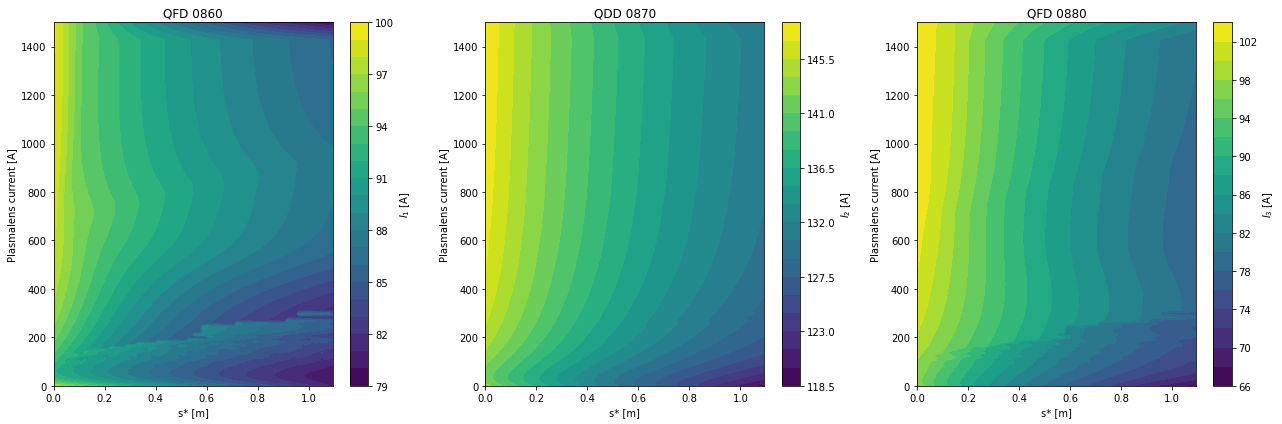

In [6]:
#------------------------------------------------------------------------------------------------
                                # MAKE CONTOUR PLOT OF CURRENTS
#------------------------------------------------------------------------------------------------
# Convert lists to array
s_plot = np.array(list_of_s[0])
#s_plot = np.array(TOTAL_s[0])
#print(s_plot)

currents = plasma_values
focus_points = s_plot
X,Y = np.meshgrid(focus_points, currents)

#print(TOTAL_I1)
Z1 = np.array(list_of_I1)
Z2 = np.array(list_of_I2)
Z3 = np.array(list_of_I3)

print(Z1.shape, Z2.shape, Z3.shape)


#axs = plt.plot(figsize=(18.6))
fig,axs = plt.subplots(1,3,figsize=(18,6))

c1 = axs[0].contourf(X,Y,Z1,levels=20,cmap='viridis')
axs[0].set_title('QFD 0860')
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_label(f'$I_1$ [A]')

c2 = axs[1].contourf(X,Y,Z2,levels=20,cmap='viridis')
axs[1].set_title('QDD 0870')
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_label(f'$I_2$ [A]')

c3 = axs[2].contourf(X,Y,Z3,levels=20,cmap='viridis')
axs[2].set_title('QFD 0880')
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_label(f'$I_3$ [A]')

for ax in axs:
    ax.set_xlabel('s* [m]')
    ax.set_ylabel('Plasmalens current [A]')
    
plt.tight_layout()
plt.show()

In [ ]:
start_time = time.time()
# ------------------------------------------------------------------------------------------------------------------------
# Lister: 
betax_star_neg     = []
betay_star_neg     = []
alphax_neg         = []
alphay_neg         = []
s_star_neg         = []
inv_beta_neg       = []
I1_neg             = []
I2_neg             = []
I3_neg             = []
sigma_x_neg        = []
sigma_y_neg        = []
sigma_x_xp_neg     = []
sigma_y_yp_neg     = []
focuslist_neg      = []  # List of focuspoints for indexing in sigma waist plots

# List of lists

list_of_s_neg         = []
list_of_betax_neg     = []
list_of_betay_neg     = []
list_of_alphax_neg    = []
list_of_alphay_neg    = []
list_of_sigmax_neg    = []
list_of_sigmay_neg    = []
list_of_sigmaxp_neg   = []
list_of_sigmayp_neg   = []
list_of_I1_neg        = []
list_of_I2_neg        = []
list_of_I3_neg        = []
FOCUS_neg             = []

betax_QF860_neg    = []
betay_QF860_neg    = []
betax_QD870_neg    = []
betay_QD870_neg    = []
betax_QF880_neg    = []
betay_QF880_neg    = []
list_of_betax860_neg  = []
list_of_betay860_neg  = []
list_of_betax870_neg  = []
list_of_betay870_neg  = []
list_of_betax880_neg  = []
list_of_betay880_neg  = []

#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
# Run optimizer for several focuspoints, with the plasmalens
#I_start = [[I1_opt_final, I2_opt_final, I3_opt_final]]
#NEW FOCUSPOINT FOR WHERE TO START THE FOCUS
focus1 = 18.4000
focusarray_neg = np.linspace(focus0, 17.4000, len(focusarray))
#focusarray = np.linspace(17.200, 19.2750, 2)
#------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------
I_plasma_neg = [[I1_opt_init, I2_opt_init, I3_opt_init]]
#plasma_values = np.linspace(0,1500,16)
#plasma_values = np.array([0.0] + list(np.logspace(0,np.log10(1500),51,base=10)))
#print(plasma_values)

for j,p in enumerate(plasma_values): 
    print(f"Iteration number {j+1} of {len(plasma_values)}")
    latticeCLEAR_PLE_focus = lattice(focus0)
    latticeCLEAR_PLE_focus.elements['PLE0800'].update(-p, P0)
    #print(f"Plasmacurrent = {p} [A]:")
    I_focus_neg = I_plasma_neg[j]
    #print(f"List of start values for the symmetrypoint for {p} [A]: {I_focus_neg}")
    bounds = [(0, 500), (0, 500), (0, 500)]

    optRes_final_neg = minimize(minFun_opt, x0=I_focus_neg, args=(focus_Index0, latticeCLEAR_PLE_focus), bounds=bounds) 
    #print(optRes_final)
    
    I1_opt_final_neg = optRes_final_neg.x[0]
    I2_opt_final_neg = optRes_final_neg.x[1]
    I3_opt_final_neg = optRes_final_neg.x[2]
    
    I_plasma_neg.append([I1_opt_final_neg, I2_opt_final_neg, I3_opt_final_neg])
    #print(f"I_plasma: {I_plasma[-1]}")
    #print(f"minFun = {minFun_opt(optRes_final.x,focus_Index0, latticeCLEAR_PLE_focus)}")
    #I_start = [[I1_opt_final, I2_opt_final, I3_opt_final]]
    #latticeCLEAR_PLE = lattice(f)
    I_start_neg = [I_plasma_neg[-1]]
    #print(f"I_start for optimizing currents in triplet = {I_start} [A]")
    #I1.clear()
    
    for i, f in enumerate(focusarray_neg): 
        # Start values
        latticeCLEAR_PLE = lattice(f)
        latticeCLEAR_PLE.elements['PLE0800'].update(-p, P0)
        #print(f"Focuspoint = {f} [m]")
        I_neg = I_start_neg[i]
        #print(f"Start values (I) for optimize for plasmacurrent = {p}: ", I)
        focus_Index = latticeCLEAR_PLE.getTwissIdx("Focus point")
        #latticeCLEAR_PLE.elements['CA.PLE0800'].update(-p, P0)
        
        # OPTIMIZE
        optR_neg = minimize(minFun_opt, I_neg, args=(focus_Index,latticeCLEAR_PLE), bounds=bounds)
    
        I1_opt_neg = optR_neg.x[0]
        I2_opt_neg = optR_neg.x[1]
        I3_opt_neg = optR_neg.x[2]
        #print(f"I1_opt = {I1_opt}, I2_opt = {I2_opt}, I3_opt = {I3_opt}")
    
        # UPDATE LATTICE
        latticeCLEAR_PLE.elements['QFD0860'].update(I1_opt_neg, P0)
        latticeCLEAR_PLE.elements['QDD0870'].update(-I2_opt_neg, P0)
        latticeCLEAR_PLE.elements['QFD0880'].update(I3_opt_neg, P0)
    
        #PROPAGATE
        (s,xt,yt, xTra,yTra, sSub,xtSub,ytSub,xTraSub,yTraSub) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)
    
        #CALCULATE SIGMA X (and Y)
        sigmax_neg = np.sqrt(xt[0, focus_Index]*epsg_x)
        sigmay_neg = np.sqrt(yt[0, focus_Index]*epsg_y)
    
        # MAKE LISTS
        focuslist_neg.append(f)
        s_star_neg.append(f-focus0) # Lage en lengdeliste til å plotte
        betax_star_neg.append(xt[0, focus_Index])
        betay_star_neg.append(yt[0, focus_Index])
        alphax_neg.append(xt[1, focus_Index])
        alphay_neg.append(yt[1, focus_Index])
        sigma_x_neg.append(sigmax_neg)
        sigma_y_neg.append(sigmay_neg)
    
        # CALCULATE SIGMA XP FROM SIGMA X
        sigma_xp_neg = (sigmax_neg / xt[0,focus_Index]) * np.sqrt(1 + xt[1, focus_Index]**2)
        sigma_x_xp_neg.append(sigma_xp_neg)
    
        sigma_yp_neg = (sigmay_neg / yt[0,focus_Index]) * np.sqrt(1 + yt[1, focus_Index]**2)
        sigma_y_yp_neg.append(sigma_yp_neg)
        
        I1_neg.append(I1_opt_neg)
        I2_neg.append(I2_opt_neg)
        I3_neg.append(I3_opt_neg)
        
        betax_QF860_neg.append(xt[0, QFD860])
        betay_QF860_neg.append(yt[0, QFD860])
        betax_QD870_neg.append(xt[0, QDD870])
        betay_QD870_neg.append(yt[0, QDD870])
        betax_QF880_neg.append(xt[0, QFD880])
        betay_QF880_neg.append(yt[0, QFD880])
        
        I_start_neg.append([optR_neg.x[0], optR_neg.x[1], optR_neg.x[2]])
        #print(f"I_start at the end of the optimization for plasma = {p}: {I_start}")
    
    # Husk at du må indeksere med : for at det skal bli riktig - hent ut verdiene inne i listene, ikke selve listene
    list_of_I1_neg.append(I1_neg[:])
    list_of_I2_neg.append(I2_neg[:])
    list_of_I3_neg.append(I3_neg[:])
    list_of_s_neg.append(s_star_neg[:])
    FOCUS_neg.append(focuslist_neg[:])
    list_of_betax_neg.append(betax_star_neg[:])
    list_of_betay_neg.append(betay_star_neg[:])
    list_of_alphax_neg.append(alphax_neg[:])
    list_of_alphay_neg.append(alphay_neg[:])
    list_of_sigmax_neg.append(sigma_x_neg[:])
    list_of_sigmaxp_neg.append(sigma_x_xp_neg[:])
    list_of_sigmay_neg.append(sigma_y_neg[:])
    list_of_sigmayp_neg.append(sigma_y_yp_neg[:])
    list_of_betax860_neg.append(betax_QF860_neg[:])
    list_of_betay860_neg.append(betay_QF860_neg[:])
    list_of_betax870_neg.append(betax_QD870_neg[:])
    list_of_betay870_neg.append(betay_QD870_neg[:])
    list_of_betax880_neg.append(betax_QF880_neg[:])
    list_of_betay880_neg.append(betay_QF880_neg[:])
    #s_star.append(f-focus0)
    
    # Clear the short list
    I_start_neg.clear()
    I1_neg.clear()
    I2_neg.clear()
    I3_neg.clear()
    s_star_neg.clear()
    betax_star_neg.clear()
    betay_star_neg.clear()
    alphax_neg.clear()
    alphay_neg.clear()
    sigma_x_neg.clear()
    sigma_x_xp_neg.clear()
    sigma_y_neg.clear()
    sigma_y_yp_neg.clear()
    focuslist_neg.clear()
    betax_QF860_neg.clear()
    betay_QF860_neg.clear()
    betax_QD870_neg.clear()
    betay_QD870_neg.clear()
    betax_QF880_neg.clear()
    betay_QF880_neg.clear()
    

#print(f"Currents in first quadrupole: {list_of_I1}")
#---------------------------------    
# Convert lists to array
s_plot = np.array(list_of_s_neg[0])

end_time = time.time()

total_time = end_time-start_time
if total_time < 60:
    print(f"Total time taken: {total_time: .2f} seconds")
else: 
    tot_min = total_time/60
    print(f"Total time taken: {tot_min: .2f} minutes")


In [ ]:
#------------------------------------------------------------------------------------------------
                                # MAKE CONTOUR PLOT OF CURRENTS
#------------------------------------------------------------------------------------------------
# Convert lists to array
s_plot = np.array(list_of_s_neg[0])
#s_plot = np.array(TOTAL_s[0])
#print(s_plot)

currents = plasma_values
focus_points = s_plot
X,Y = np.meshgrid(focus_points, currents)

#print(TOTAL_I1)
Z1 = np.array(list_of_I1_neg)
Z2 = np.array(list_of_I2_neg)
Z3 = np.array(list_of_I3_neg)

print(Z1.shape, Z2.shape, Z3.shape)


#axs = plt.plot(figsize=(18.6))
fig,axs = plt.subplots(1,3,figsize=(18,6))

c1 = axs[0].contourf(X,Y,Z1,levels=20,cmap='viridis')
axs[0].set_title('QFD 0860')
cb1 = fig.colorbar(c1, ax=axs[0])
cb1.set_label(f'$I_1$ [A]')

c2 = axs[1].contourf(X,Y,Z2,levels=20,cmap='viridis')
axs[1].set_title('QDD 0870')
cb2 = fig.colorbar(c2, ax=axs[1])
cb2.set_label(f'$I_2$ [A]')

c3 = axs[2].contourf(X,Y,Z3,levels=20,cmap='viridis')
axs[2].set_title('QFD 0880')
cb3 = fig.colorbar(c3, ax=axs[2])
cb3.set_label(f'$I_3$ [A]')

for ax in axs:
    ax.set_xlabel('s* [m]')
    ax.set_ylabel('Plasmalens current [A]')
    
plt.tight_layout()
plt.show()

## Combine lists 

In [ ]:
#DO NOT RUN THIS CELL MORE THAN ONCE!!!!

for i in range(len(plasma_values)):
    del FOCUS_neg[i][0]
    FOCUS_neg[i].reverse()
    
    del list_of_I1_neg[i][0]
    list_of_I1_neg[i].reverse()
    
    del list_of_I2_neg[i][0]
    list_of_I2_neg[i].reverse()
    
    del list_of_I3_neg[i][0]
    list_of_I3_neg[i].reverse()
    
    del list_of_betax_neg[i][0]
    list_of_betax_neg[i].reverse()
    
    del list_of_betay_neg[i][0]
    list_of_betay_neg[i].reverse()
    
    del list_of_alphax_neg[i][0]
    list_of_alphax_neg[i].reverse()
    
    del list_of_alphay_neg[i][0]
    list_of_alphay_neg[i].reverse()
    
    del list_of_sigmax_neg[i][0]
    list_of_sigmax_neg[i].reverse()
    
    del list_of_sigmaxp_neg[i][0]
    list_of_sigmaxp_neg[i].reverse()
    
    del list_of_sigmay_neg[i][0]
    list_of_sigmay_neg[i].reverse()
    
    del list_of_sigmayp_neg[i][0]
    list_of_sigmayp_neg[i].reverse()
    
    del list_of_s_neg[i][0]
    list_of_s_neg[i].reverse()
    
    del list_of_betax860_neg[i][0]
    list_of_betax860_neg[i].reverse()
    
    del list_of_betay860_neg[i][0]
    list_of_betay860_neg[i].reverse()
    
    del list_of_betax870_neg[i][0]
    list_of_betax870_neg[i].reverse()
    
    del list_of_betay870_neg[i][0]
    list_of_betay870_neg[i].reverse()
    
    del list_of_betax880_neg[i][0]
    list_of_betax880_neg[i].reverse()
    
    del list_of_betay880_neg[i][0]
    list_of_betay880_neg[i].reverse()

#print(list_of_betax860_neg[0])

In [ ]:

# ---------- Join the lists together --------------------------------------------------

for i in range(len(plasma_values)):
    list_of_s_neg[i].extend(list_of_s[i])
    TOTAL_s = np.array(list_of_s_neg, dtype=object)
    
    list_of_I1_neg[i].extend(list_of_I1[i])
    TOTAL_I1 = list_of_I1_neg
    
    list_of_I2_neg[i].extend(list_of_I2[i])
    TOTAL_I2 = list_of_I2_neg
    
    list_of_I3_neg[i].extend(list_of_I3[i])
    TOTAL_I3 = list_of_I3_neg
    
    list_of_betax_neg[i].extend(list_of_betax[i])
    TOTAL_BETAX = list_of_betax_neg
    
    list_of_betay_neg[i].extend(list_of_betay[i])
    TOTAL_BETAY = list_of_betay_neg
    
    list_of_alphax_neg[i].extend(list_of_alphax[i])
    TOTAL_ALPHAx = list_of_alphax_neg
    
    list_of_alphay_neg[i].extend(list_of_alphay[i])
    TOTAL_ALPHAY = list_of_alphay_neg
    
    list_of_sigmax_neg[i].extend(list_of_sigmax[i])
    TOTAL_SIGMAX = list_of_sigmax_neg
    
    list_of_sigmaxp_neg[i].extend(list_of_sigmaxp[i])
    TOTAL_SIGMAXP = list_of_sigmaxp_neg
    
    list_of_sigmay_neg[i].extend(list_of_sigmay[i])
    TOTAL_SIGMAY = list_of_sigmay_neg
    
    list_of_sigmayp_neg[i].extend(list_of_sigmayp[i])
    TOTAL_SIGMAYP = list_of_sigmayp_neg
    
    FOCUS_neg[i].extend(FOCUS[i])
    TOTAL_FOCUS = FOCUS_neg
    
    list_of_betax860_neg[i].extend(list_of_betax860[i])
    TOTAL_betax860 = list_of_betax860_neg
    
    list_of_betay860_neg[i].extend(list_of_betay860[i])
    TOTAL_betay860 = list_of_betay860_neg
    
    list_of_betax870_neg[i].extend(list_of_betax870[i])
    TOTAL_betax870 = list_of_betax870_neg
    
    list_of_betay870_neg[i].extend(list_of_betay870[i])
    TOTAL_betay870 = list_of_betay870_neg
    
    list_of_betax880_neg[i].extend(list_of_betax880[i])
    TOTAL_betax880 = list_of_betax880_neg
    
    list_of_betay880_neg[i].extend(list_of_betay880[i])
    TOTAL_betay880 = list_of_betay880_neg
    
#print(TOTAL_betay880)

## Save to file

In [ ]:
# Convert to DataFrame
df_I1_total = pd.DataFrame(TOTAL_I1)
df_I2_total = pd.DataFrame(TOTAL_I2)
df_I3_total = pd.DataFrame(TOTAL_I3)
df_s_total = pd.DataFrame(TOTAL_s[0])
df_betax_total = pd.DataFrame(TOTAL_BETAX)
df_betay_total = pd.DataFrame(TOTAL_BETAY)
df_focus_total = pd.DataFrame(TOTAL_FOCUS[0])
df_alphax_total = pd.DataFrame(TOTAL_ALPHAx)
df_alphay_total = pd.DataFrame(TOTAL_ALPHAY)
df_sigmax_total = pd.DataFrame(TOTAL_SIGMAX)
df_sigmaxp_total = pd.DataFrame(TOTAL_SIGMAXP)
df_sigmay_total = pd.DataFrame(TOTAL_SIGMAY)
df_sigmayp_total = pd.DataFrame(TOTAL_SIGMAYP)
df_k1_total = pd.DataFrame(TOTAL_k1)
df_k2_total = pd.DataFrame(TOTAL_k2)
df_k3_total = pd.DataFrame(TOTAL_k3)
df_betax860_total = pd.DataFrame(TOTAL_betax860)
df_betay860_total = pd.DataFrame(TOTAL_betay860)
df_betax870_total = pd.DataFrame(TOTAL_betax870)
df_betay870_total = pd.DataFrame(TOTAL_betay870)
df_betax880_total = pd.DataFrame(TOTAL_betax880)
df_betay880_total = pd.DataFrame(TOTAL_betay880)

# Save to different sheets in the same Excel file
with pd.ExcelWriter(f'APL_optimization.xlsx') as writer:
    df_s_total.to_excel(writer, sheet_name='list_of_s', index=False)
    df_focus_total.to_excel(writer, sheet_name='Focus_points', index=False)
    df_I1_total.to_excel(writer, sheet_name='list_of_I1', index=False)
    df_I2_total.to_excel(writer, sheet_name='list_of_I2', index=False)
    df_I3_total.to_excel(writer, sheet_name='list_of_I3', index=False)
    df_betax_total.to_excel(writer, sheet_name='list_of_betaX', index=False)
    df_betay_total.to_excel(writer, sheet_name='list_of_betaY', index=False)
    df_alphax_total.to_excel(writer, sheet_name='list_of_alphaX', index=False)
    df_alphay_total.to_excel(writer, sheet_name='list_of_alphaY', index=False)
    df_sigmax_total.to_excel(writer, sheet_name='list_of_sigmaX', index=False)
    df_sigmaxp_total.to_excel(writer, sheet_name='list_of_sigmaXP', index=False)
    df_sigmay_total.to_excel(writer, sheet_name='list_of_sigmaY', index=False)
    df_sigmayp_total.to_excel(writer, sheet_name='list_of_sigmaYP', index=False)
    df_k1_total.to_excel(writer, sheet_name='list_of_k1', index=False)
    df_k2_total.to_excel(writer, sheet_name='list_of_k2', index=False)
    df_k3_total.to_excel(writer, sheet_name='list_of_k3', index=False)
    df_betax860_total.to_excel(writer, sheet_name='list_of_betax860', index=False)
    df_betay860_total.to_excel(writer, sheet_name='list_of_betay860', index=False)
    df_betax870_total.to_excel(writer, sheet_name='list_of_betax870', index=False)
    df_betay870_total.to_excel(writer, sheet_name='list_of_betay870', index=False)
    df_betax880_total.to_excel(writer, sheet_name='list_of_betax880', index=False)
    df_betay880_total.to_excel(writer, sheet_name='list_of_betay880', index=False)


print("Data saved to file")

## Visualize beam propagation for any focus point, at any APL current

In [ ]:

def latticeplot(plasma,focus): 

    target1 = plasma
    closest_value1 = min(plasma_values, key=lambda x: abs(x - target1))
    print(f"The closest value to plasma current {target1} is {closest_value1}")
    index1 = list(plasma_values).index(closest_value1)
    
    target2 = focus
    closest_value2 = min(TOTAL_FOCUS[0], key=lambda x: abs(x-target2))
    print(f"The closest value to focus point {target2} is {closest_value2}")
    index2 = TOTAL_FOCUS[0].index(closest_value2)

    I4_plot = plasma_values[index1]
    I1_plot = TOTAL_I1[index1][index2]
    I2_plot = TOTAL_I2[index1][index2]
    I3_plot = TOTAL_I3[index1][index2]

    s_line = TOTAL_FOCUS[0][index2]
    print(f"Focus point (original coordinate) = {s_line} [m] for plasmacurrent = {I4_plot} [A]")


    latticeCLEAR_PLE = lattice(s_line)

    latticeCLEAR_PLE.elements['QFD0860'].update(I1_plot, P0)
    latticeCLEAR_PLE.elements['QDD0870'].update(-I2_plot, P0)
    latticeCLEAR_PLE.elements['QFD0880'].update(I3_plot, P0)
    latticeCLEAR_PLE.elements['PLE0800'].update(-I4_plot, P0)

    (sp,xtp,ytp, xTrap,yTrap, sSubp,xtSubp,ytSubp,xTraSubp,yTraSubp) = latticeCLEAR_PLE.computeTwiss(xt_init,yt_init, subdivide=1e-3)

    (ax_beta_p,ax_alpha_p) = plot.alphaBeta(sp,xtSubp,ytSubp, sSubp)
    plot.addElemsToPlot(ax_beta_p,latticeCLEAR_PLE)
    plot.addElemsToPlot(ax_alpha_p,latticeCLEAR_PLE)
    plot.addElemNamesToPlot(ax_beta_p,latticeCLEAR_PLE, ypos=1.1)
    plt.gcf().set_figwidth(20)

    ## Let's plot the beam sigmas
    (ax1_p,ax2_p) = plot.sigmas(sp,xtSubp,ytSubp,(epsg_x,epsg_y), xTraSubp,yTraSubp, sSub=sSubp, equalY=True)
    plot.addElemsToPlot(ax1_p,latticeCLEAR_PLE)
    plot.addElemsToPlot(ax2_p,latticeCLEAR_PLE)
    plot.addElemNamesToPlot(ax1_p,latticeCLEAR_PLE, ypos=1.1)
    plt.gcf().set_figwidth(20)
    
    A = 1/(np.pi*xtSubp[0]*ytSubp[0])
    plt.figure()
    plt.plot(sSubp, A)
    plt.title(f'$1/(\pi\sigma_x\sigma_y$)')
    plt.xlabel('s [m]')
    plt.ylabel(f'[mm$^2$]')

    plt.show()

    return opticsUtils.printLatticeOptics(latticeCLEAR_PLE, sp, xtp, ytp, epsg_x,epsg_y, xTrap, yTrap)

#-----------------------------------------------------------------------------------------------------------------------------
## PLOT THE WAIST USING PLASMA CURRENT IN [A] and focus point from coordinate s from original, full lattice
# CALL FUNCTION AS latticeplot(APL, focus)
waist = latticeplot(100, 18.5)




